In [1]:
import os
import numpy as np
import pandas as pd # alias
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('data/processed/bookings_Missingvals_Handled.csv')
df.head(5)

,booking_id,citizen_id,booking_date,appointment_date,appointment_time,task_id,num_documents,queue_number,satisfaction_rating,employees_on_duty,duration_minutes
0,f7b59ba3793fea61282cb02be2247cebd0a75306,4229044420,2021-01-01,2021-01-01,09:03,TASK-002,0,2,4,1,37
1,cfe30d53b4b645e4cb6b114f6c9d74a0f25e6a80,5389442635,2021-01-01,2021-01-01,09:12,TASK-001,1,1,4,1,60
2,0fb0a5d9b3944dd743a9e7828dc03fa74aa6ebf8,2123783919,2021-01-01,2021-01-01,09:36,TASK-002,1,6,5,1,57
3,d4bf826153212fa325ad98b215668ab942365607,6359918966,2021-01-01,2021-01-01,09:45,TASK-001,1,4,4,1,53
4,ebb4c9687acbaf65376d8e379bd1341d1c15127e,178732202,2021-01-01,2021-01-01,10:12,TASK-002,1,8,3,1,88


In [3]:
# Create time bins
df['time_bin'] = pd.cut(pd.to_datetime(df['appointment_time']).dt.hour, 
                        bins=[0, 11, 14, 24], 
                        labels=['0-11', '11-14', '14-24'], 
                        include_lowest=True)


/var/folders/lx/fj0jgh0s0rg95r58q33kw2b40000gn/T/ipykernel_1031/3170912881.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['time_bin'] = pd.cut(pd.to_datetime(df['appointment_time']).dt.hour,


In [4]:
# Check appointment_date for invalid formats
df['date_parsed'] = pd.to_datetime(df['appointment_date'], errors='coerce', format='%Y-%m-%d')
invalid_dates = df[df['date_parsed'].isna()][['appointment_date']].drop_duplicates()
print("\nInvalid appointment_dates (could not parse as YYYY-MM-DD):")
print(invalid_dates if not invalid_dates.empty else "None found")

# Check appointment_time for invalid formats
def parse_time(time_str):
    try:
        dt = pd.to_datetime(time_str, format='%H:%M')
        if 0 <= dt.hour <= 23 and 0 <= dt.minute <= 59:
            return dt.time()
        else:
            return None
    except ValueError:
        return None

df['time_parsed'] = df['appointment_time'].apply(parse_time)
invalid_times = df[df['time_parsed'].isna()][['appointment_time']].drop_duplicates()
print("\nInvalid appointment_times (not HH:MM or outside 00:00-23:59):")
print(invalid_times if not invalid_times.empty else "None found")

# 5. Summary counts
print("\nSummary:")
print(f"Total rows: {len(df)}")
print(f"Unique invalid dates: {len(invalid_dates)}")
print(f"Unique invalid times: {len(invalid_times)}")

# Optional: Clean up temporary columns
df.drop(['date_parsed', 'time_parsed', 'appointment_hour'], axis=1, inplace=True, errors='ignore')


Invalid appointment_dates (could not parse as YYYY-MM-DD):
None found

Invalid appointment_times (not HH:MM or outside 00:00-23:59):
None found

Summary:
Total rows: 203693
Unique invalid dates: 0
Unique invalid times: 0


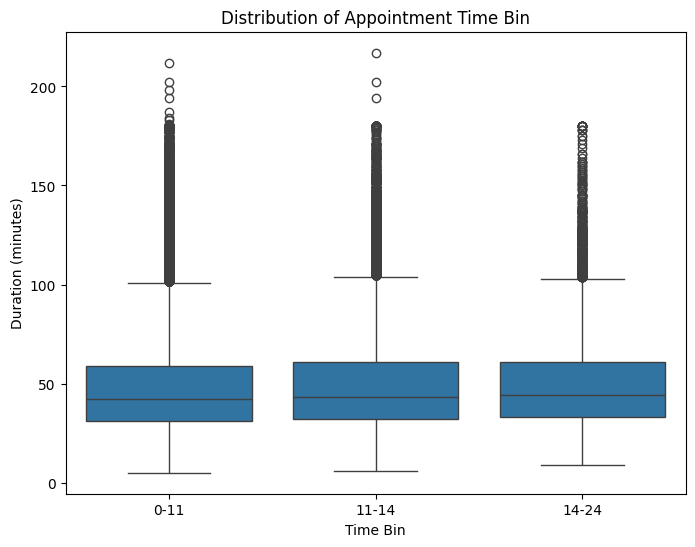

count    203693.000000
mean         48.270402
std          23.838884
min           5.000000
25%          31.000000
50%          42.000000
75%          59.000000
max         217.000000
Name: duration_minutes, dtype: float64

By Time Bin:
             count       mean        std  min   25%   50%   75%    max
time_bin                                                              
0-11      142529.0  47.744768  23.539890  5.0  31.0  42.0  59.0  212.0
11-14      50856.0  49.386542  24.415894  6.0  32.0  43.0  61.0  217.0
14-24      10308.0  50.031723  24.775861  9.0  33.0  44.0  61.0  180.0


/var/folders/lx/fj0jgh0s0rg95r58q33kw2b40000gn/T/ipykernel_1031/1455245102.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('time_bin')['duration_minutes'].describe())


In [5]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df,  x='time_bin', y='duration_minutes')
plt.title('Distribution of Appointment Time Bin')
plt.xlabel('Time Bin')
plt.ylabel('Duration (minutes)')
plt.show()

# Summary statistics
print(df['duration_minutes'].describe())
print("\nBy Time Bin:")
print(df.groupby('time_bin')['duration_minutes'].describe())

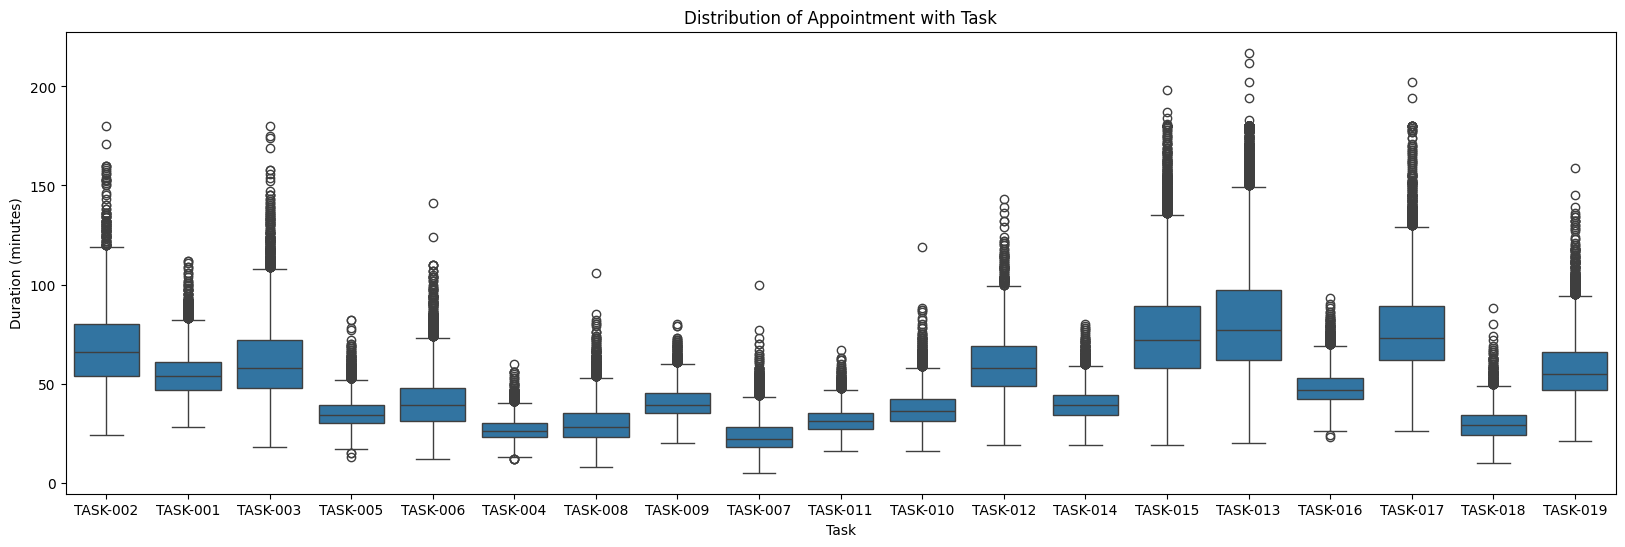


By Task:
            count       mean        std   min   25%   50%   75%    max
task_id                                                               
TASK-001  11065.0  54.999638  10.786028  28.0  47.0  54.0  61.0  112.0
TASK-002   5407.0  68.542075  19.977235  24.0  54.0  66.0  80.0  180.0
TASK-003   7123.0  61.609013  19.986348  18.0  48.0  58.0  72.0  180.0
TASK-004   9816.0  26.806438   5.592079  12.0  23.0  26.0  30.0   60.0
TASK-005  16750.0  35.198030   7.055405  13.0  30.0  34.0  39.0   82.0
TASK-006   6279.0  41.407708  14.234588  12.0  31.0  39.0  48.0  141.0
TASK-007  13057.0  23.649383   7.909796   5.0  18.0  22.0  28.0  100.0
TASK-008  12621.0  29.593614   9.213357   8.0  23.0  28.0  35.0  106.0
TASK-009   7841.0  40.246015   7.434977  20.0  35.0  39.0  45.0   80.0
TASK-010  10320.0  37.005717   8.712130  16.0  31.0  36.0  42.0  119.0
TASK-011  11236.0  31.454610   5.756085  16.0  27.0  31.0  35.0   67.0
TASK-012   5638.0  59.679319  15.393302  19.0  49.0  58.0  69.0  14

In [6]:
plt.figure(figsize=(20, 6))
sns.boxplot(data=df,  x='task_id', y='duration_minutes')
plt.title('Distribution of Appointment with Task')
plt.xlabel('Task')
plt.ylabel('Duration (minutes)')
plt.show()

# Summary statistics
print("\nBy Task:")
print(df.groupby('task_id')['duration_minutes'].describe())

Task 2, 12, 13, 15 Tend to have more time compared with others

In [7]:
def find_anomaly(data):

    mean = data.mean()
    std = data.std()

    upper_bound = mean + (3 * std)
    lower_bound = mean - (3 * std)

    return (data > upper_bound) | (data < lower_bound)

# Find outliers by task_id
outlier_counts = {}
for task_id in df['task_id'].unique():
    task_data = df[df['task_id'] == task_id]['duration_minutes']
    outliers = find_anomaly(task_data)
    n_outliers = outliers.sum()
    n_outlier_percentage = round(n_outliers / len(task_data), 3)
    outlier_counts[task_id] = (n_outliers, n_outlier_percentage)

# Display results
for task_id, (count, percentage) in outlier_counts.items():
    print(f"Task {task_id}: {count} outliers ({percentage} %)")

# Total outliers across all tasks
total_outliers = sum(count for count, _ in outlier_counts.values())
total_percentage = round(total_outliers / len(df), 3)
print(f"\nTotal: {total_outliers} outliers ({total_percentage} %)")

Task TASK-002: 56 outliers (0.01 %)
Task TASK-001: 93 outliers (0.008 %)
Task TASK-003: 85 outliers (0.012 %)
Task TASK-005: 114 outliers (0.007 %)
Task TASK-006: 76 outliers (0.012 %)
Task TASK-004: 72 outliers (0.007 %)
Task TASK-008: 125 outliers (0.01 %)
Task TASK-009: 66 outliers (0.008 %)
Task TASK-007: 147 outliers (0.011 %)
Task TASK-011: 98 outliers (0.009 %)
Task TASK-010: 84 outliers (0.008 %)
Task TASK-012: 51 outliers (0.009 %)
Task TASK-014: 91 outliers (0.007 %)
Task TASK-015: 166 outliers (0.012 %)
Task TASK-013: 211 outliers (0.014 %)
Task TASK-016: 78 outliers (0.006 %)
Task TASK-017: 104 outliers (0.009 %)
Task TASK-018: 69 outliers (0.009 %)
Task TASK-019: 109 outliers (0.009 %)

Total: 1895 outliers (0.009 %)


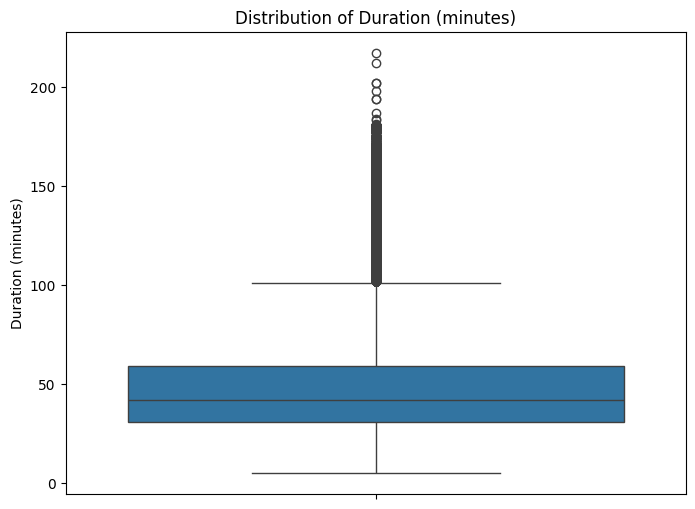

count    203693.000000
mean         48.270402
std          23.838884
min           5.000000
25%          31.000000
50%          42.000000
75%          59.000000
max         217.000000
Name: duration_minutes, dtype: float64


In [8]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, y='duration_minutes')
plt.title('Distribution of Duration (minutes)')
plt.ylabel('Duration (minutes)')
plt.show()

# Summary statistics
print(df['duration_minutes'].describe())

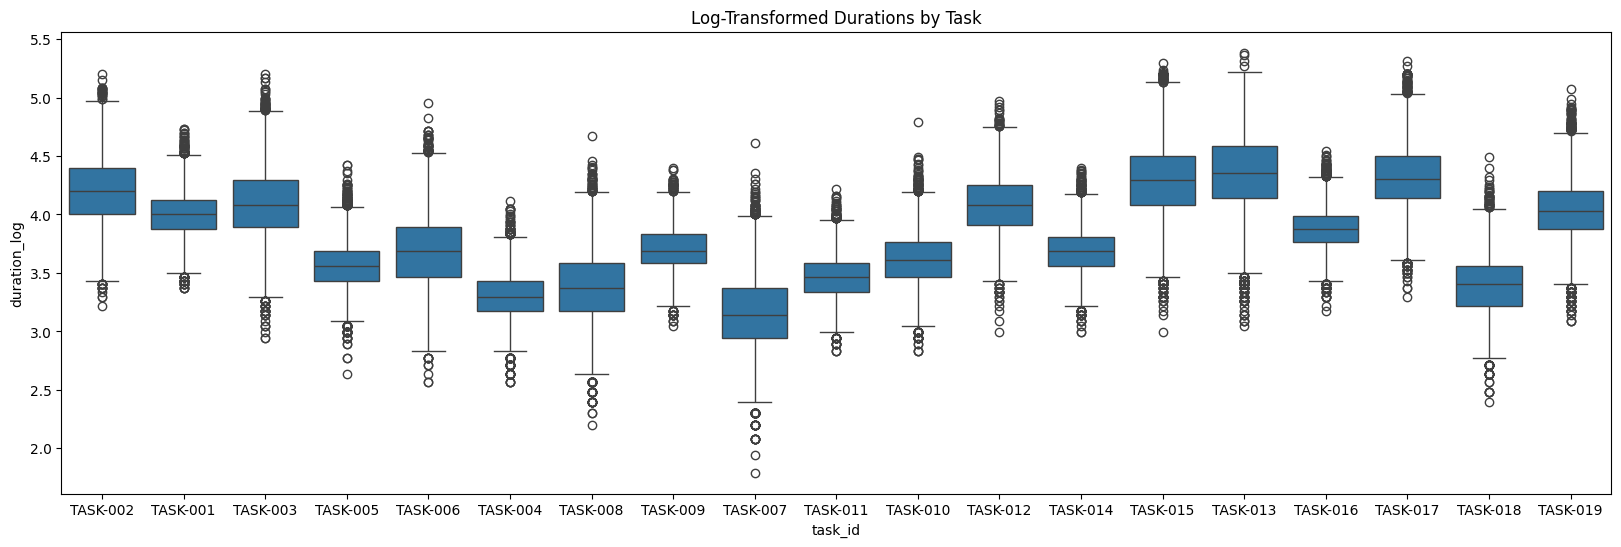

In [9]:
from scipy.stats.mstats import winsorize

# Log Transformation (with +1 for zeros)
def log_transform(X):
    return np.log1p(X)

# Apply per task (example)
df['duration_log'] = df.groupby('task_id')['duration_minutes'].transform(log_transform)

# Visualize after
plt.figure(figsize=(20, 6))
sns.boxplot(data=df, x='task_id', y='duration_log')
plt.title('Log-Transformed Durations by Task')
plt.show()


In [10]:
df.head()

,booking_id,citizen_id,booking_date,appointment_date,appointment_time,task_id,num_documents,queue_number,satisfaction_rating,employees_on_duty,duration_minutes,time_bin,duration_log
0,f7b59ba3793fea61282cb02be2247cebd0a75306,4229044420,2021-01-01,2021-01-01,09:03,TASK-002,0,2,4,1,37,0-11,3.637586
1,cfe30d53b4b645e4cb6b114f6c9d74a0f25e6a80,5389442635,2021-01-01,2021-01-01,09:12,TASK-001,1,1,4,1,60,0-11,4.110874
2,0fb0a5d9b3944dd743a9e7828dc03fa74aa6ebf8,2123783919,2021-01-01,2021-01-01,09:36,TASK-002,1,6,5,1,57,0-11,4.060443
3,d4bf826153212fa325ad98b215668ab942365607,6359918966,2021-01-01,2021-01-01,09:45,TASK-001,1,4,4,1,53,0-11,3.988984
4,ebb4c9687acbaf65376d8e379bd1341d1c15127e,178732202,2021-01-01,2021-01-01,10:12,TASK-002,1,8,3,1,88,0-11,4.488636


In [11]:
# Function to detect outliers per task using IQR
def detect_outliers1(group):
    Q1 = group['duration_log'].quantile(0.25)
    Q3 = group['duration_log'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = group[(group['duration_log'] < lower_bound) | (group['duration_log'] > upper_bound)]
    return outliers


# Get outliers by task
outliers_df1 = df.groupby('task_id').apply(detect_outliers1)

# Summary
print("Outliers Summary:")
print(outliers_df1['task_id'].value_counts())

# Get total sum of outliers
total_outliers = len(outliers_df1)
print(f"\nTotal number of outliers: {total_outliers}")


Outliers Summary:
task_id
TASK-005    169
TASK-016    132
TASK-019    129
TASK-004    118
TASK-007    111
TASK-008    108
TASK-010    104
TASK-015     98
TASK-014     97
TASK-013     95
TASK-017     92
TASK-001     92
TASK-018     80
TASK-003     79
TASK-011     70
TASK-009     57
TASK-006     54
TASK-012     47
TASK-002     37
Name: count, dtype: int64

Total number of outliers: 1769


/var/folders/lx/fj0jgh0s0rg95r58q33kw2b40000gn/T/ipykernel_1031/2756616869.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  outliers_df1 = df.groupby('task_id').apply(detect_outliers1)


In [12]:
# # 2. Winsorization (cap at 5th/95th percentiles per task)
# def winsorize_per_group(x):
#     return winsorize(x, limits=[0.05, 0.05])

# df['duration_winsor'] = df.groupby('task_id')['duration_log'].transform(winsorize_per_group)

# # Visualize
# plt.figure(figsize=(20, 6))
# sns.boxplot(data=df, x='task_id', y='duration_winsor')
# plt.title('Winsorized + Log Transformed Durations by Task')
# plt.show()

In [13]:
df = df.drop('time_bin', axis=1)

In [14]:
df.to_csv('data/processed/bookings_Outliers_Handled.csv', index=False)
df.head()

,booking_id,citizen_id,booking_date,appointment_date,appointment_time,task_id,num_documents,queue_number,satisfaction_rating,employees_on_duty,duration_minutes,duration_log
0,f7b59ba3793fea61282cb02be2247cebd0a75306,4229044420,2021-01-01,2021-01-01,09:03,TASK-002,0,2,4,1,37,3.637586
1,cfe30d53b4b645e4cb6b114f6c9d74a0f25e6a80,5389442635,2021-01-01,2021-01-01,09:12,TASK-001,1,1,4,1,60,4.110874
2,0fb0a5d9b3944dd743a9e7828dc03fa74aa6ebf8,2123783919,2021-01-01,2021-01-01,09:36,TASK-002,1,6,5,1,57,4.060443
3,d4bf826153212fa325ad98b215668ab942365607,6359918966,2021-01-01,2021-01-01,09:45,TASK-001,1,4,4,1,53,3.988984
4,ebb4c9687acbaf65376d8e379bd1341d1c15127e,178732202,2021-01-01,2021-01-01,10:12,TASK-002,1,8,3,1,88,4.488636
